# NYC MTA Data

## 1. Importing & Cleaning the Data

### Import Libraries/Packages

In [6]:
import os
import pandas as pd
import numpy as np

In [7]:
ts_dir = './data/turnstile/'

### Use Generator to Create a DataFrame with all Turnstile Information

In [8]:
ts_gen = os.walk(ts_dir)

for txt in ts_gen:
    ts_list = txt[2]

In [9]:
df_each = (pd.read_table(ts_dir+txt_file, sep=',') for txt_file in ts_list)
df = pd.concat(df_each, ignore_index=True)
df['DATETIME'] = df['DATE'] + ' ' + df["TIME"]

In [10]:
df.size

359659703

##### Sample of Data

In [11]:
df.sample(5)

,C/A,DATE,DESC,DIVISION,ENTRIES,EXITS,LINENAME,SCP,STATION,TIME,UNIT,Unnamed: 0,DATETIME
16983129,D012,06/27/2016,REGULAR,BMT,8167414.0,4052136.0,N,00-00-02,KINGS HWY,21:00:00,R395,NaN,06/27/2016 21:00:00
7110222,N023,07/08/2015,REGULAR,IND,1651604.0,2918374.0,BC,01-00-01,135 ST,05:00:00,R332,NaN,07/08/2015 05:00:00
26122148,H008,05/22/2017,REGULAR,BMT,2267621.0,12934385.0,L,01-00-01,1 AV,12:00:00,R248,NaN,05/22/2017 12:00:00
16949446,R612,06/19/2016,REGULAR,IRT,176667.0,59790.0,BDNQR2345,01-00-00,ATL AV-BARCLAY,16:00:00,R057,NaN,06/19/2016 16:00:00
12390439,N603,01/14/2016,REGULAR,IND,6006892.0,8384878.0,F,00-00-00,21 ST-QNSBRIDGE,23:00:00,R303,NaN,01/14/2016 23:00:00


##### Correct Station Names for stations appearing as multiple stations

In [12]:
df.loc[df['STATION'] == 'CENTRAL AV', 'STATION'] = 'CENTRAL AVE'
df.loc[df['STATION'] == 'DEKALB AV', 'STATION'] = 'DEKALB AVE'

##### Create a new DataFrame where it includes only *Dekalb Avenue* for the four weeks around July 1st 2017

In [13]:
df_new = df.loc[df['STATION'] == 'DEKALB AVE']
# df_new = df_new.loc[pd.to_datetime(df_new['DATE']) >= pd.to_datetime('2017-06-17')]
df_new['DATETIME'] = pd.to_datetime(df_new['DATETIME'], format='%m/%d/%Y %H:%M:%S') # Convert DATETIME column to datetime type

/Users/rezarad/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


##### Create a Function to find the delta for ENTRIES and EXITS

In [14]:
def turnstile_delta_grouped(grouped, col):
    values = []
    values_shifted = []

    for name, group in grouped:
        values.append(group[col].values[0])
        values_shifted.append(group[col].values[0])

    values_shifted.pop()
    values_shifted.insert(0, 0)

    values_final = np.array(values) - np.array(values_shifted)
    values_final = values_final.tolist()
    values_final[0] = 0
    
    return np.array(values_final)

In [15]:
def turnstile_delta(x):
    x = x.tolist()

    values = x
    values_shifted = x[1:]

    values_shifted.insert(-1,0)
    
    values_final = np.array(values_shifted) - np.array(values)
    values_final = values_final.tolist()
    values_final[0] = 0

    return np.array(values_final)


#### Create a new DataFrame with Updated Entry and Exit Data 

In [16]:
entries = np.abs(turnstile_delta(df_new['ENTRIES']))
exits = np.abs(turnstile_delta(df_new['EXITS                                                               ']))

In [17]:
diff_df = pd.DataFrame({'ENTRIES': entries, 
                        'EXITS' : exits})

In [18]:
diff_df.loc[diff_df['ENTRIES'] > 3000] = 0
diff_df.loc[diff_df['EXITS'] > 3000] = 0

##### Update DataFrame Entries and Exit Values

In [19]:
df_new.loc[:, 'ENTRIES'] = diff_df['ENTRIES'].values
df_new.loc[:, 'EXITS                                                               '] = diff_df['EXITS'].values

/Users/rezarad/Code/repos/nycmta/nycmta/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
df_new.sample(5)

,C/A,DATE,DESC,DIVISION,ENTRIES,EXITS,LINENAME,SCP,STATION,TIME,UNIT,Unnamed: 0,DATETIME
6317482,C008,06/12/2015,REGULAR,BMT,0.0,0.0,BDNQR,00-00-02,DEKALB AVE,20:00:00,R099,NaN,2015-06-12 20:00:00
19293352,C008,09/23/2016,REGULAR,BMT,187.0,208.0,BDNQR,00-03-01,DEKALB AVE,08:00:00,R099,NaN,2016-09-23 08:00:00
14648241,C008,04/03/2016,REGULAR,BMT,24.0,14.0,BDNQR,00-00-02,DEKALB AVE,00:00:00,R099,NaN,2016-04-03 00:00:00
5947033,H023,05/23/2015,REGULAR,BMT,87.0,35.0,L,00-06-02,DEKALB AVE,04:00:00,R236,NaN,2015-05-23 04:00:00
1888537,C008,12/27/2014,REGULAR,BMT,40.0,59.0,BDNQR,00-00-02,DEKALB AVE,07:00:00,R099,NaN,2014-12-27 07:00:00


## 2. Exploring the Data

In [41]:
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns

%matplotlib inline
# sns.set_style('ticks')

In [23]:
# avg_by_day = df_new.groupby('DATE').apply(np.mean)
avg_by_time = df_new.groupby(pd.to_datetime(df_new['TIME'], format='%H:%M:%S')).apply(np.mean)
avg_by_dtime = df_new.groupby(df_new['DATETIME']).apply(np.mean)

In [25]:
# avg_by_day.plot(kind='bar',
#                 title='Entries/Exits by Day: Dekalb Ave',
#                 figsize=(20,5),
#                 fontsize=12)

In [29]:
# avg_by_time.plot(kind='line',
#                 title='Entries/Exits by Time of Day: Dekalb Ave',
#                 figsize=(10,5),
#                 fontsize=12)

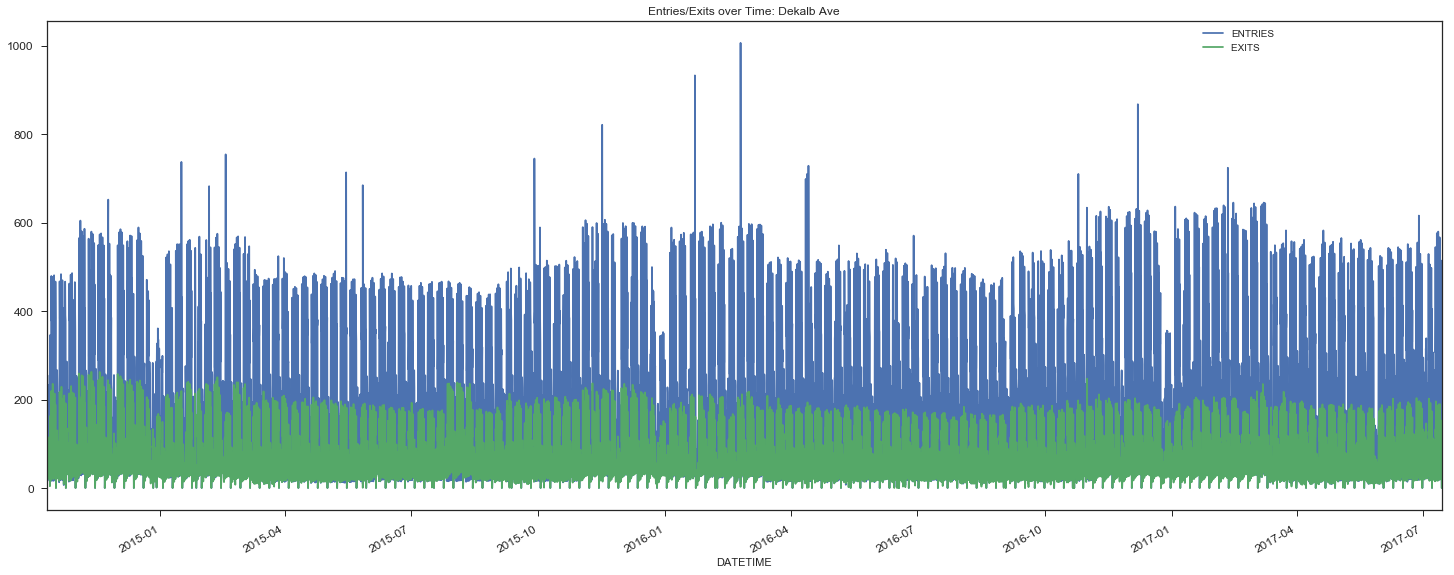

In [44]:
avg_by_dtime.plot(kind='line',
                title='Entries/Exits over Time: Dekalb Ave',
                figsize=(25,10),
                fontsize=12)

In [706]:
entries_all = np.abs(turnstile_delta(df['ENTRIES']))
exits_all = np.abs(turnstile_delta(df['EXITS                                                               ']))

In [708]:
len(entries_all)

27666131